In [1]:
import os,sys
import csv
import copy
import math
import collections
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
from IPython.display import HTML
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d
from scipy import signal
sys.path.append("/pymorph")

import logging
logger = logging.getLogger('pyclaw')
logger.setLevel(logging.CRITICAL)

import morph_geom_lib as mgl
import models.shallow_depth_morph_models as sdmodels
import schemes.avalanche_scheme 
import utils.post_processing as post

from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex
from matplotlib import animation, rc

import schemes.weno as weno
import sediment_transport.sed_trans as sedtrans
from schemes.avalanche_scheme import avalanche_model, get_slope
from models.shallow_water_solver import shallow_water_solver

rc('animation', html='html5')
%matplotlib widget
%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.style.use(['default'])

# Testing of the Non-equilibrium Bedload Model

dx: 0.8682235195996664 cm
nx 1200


Text(0, 0.5, 'z (m)')

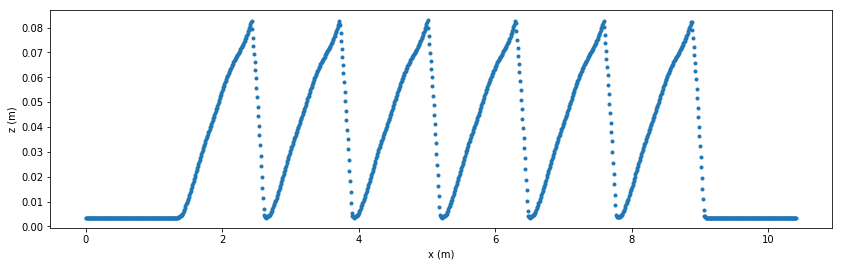

In [89]:
filepath = '../Paper_3/dune_profile_dune5_rep_runway.txt'

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    


def readFile(filepath, resolution_cells = 800):
    xs = []
    zs = []
    with open(filepath) as f:
        for line in f:
            values = line.split(',')
            if is_number(values[0]) and is_number(values[1]):
                x = float(values[0])
                z = float(values[1])
                xs.append(x)
                zs.append(z)
                
    xs = np.array(xs)
    zs = np.array(zs)
    
    #--------------------------------
    # Increase the resolution on the grid
    #--------------------------------
    xmax = xs.max()
    nx = len(xs)
    f = interp1d(xs, zs)
    
    xnew = np.linspace(0., xmax, num=resolution_cells)
    znew = f(xnew)
    return xnew, znew

x0,z0 = readFile(filepath, resolution_cells = 1200)

dx = x0[1] - x0[0]

print('dx: {0} cm'.format(dx*100.))
print('nx {0}'.format(len(x0)))

fig = plt.figure(figsize=(14, 4))
plt.plot(x0,z0, '.')
plt.xlabel('x (m)')
plt.ylabel('z (m)')

0.8
0.8786938680574733
0.9264241117657115
0.955373967970314


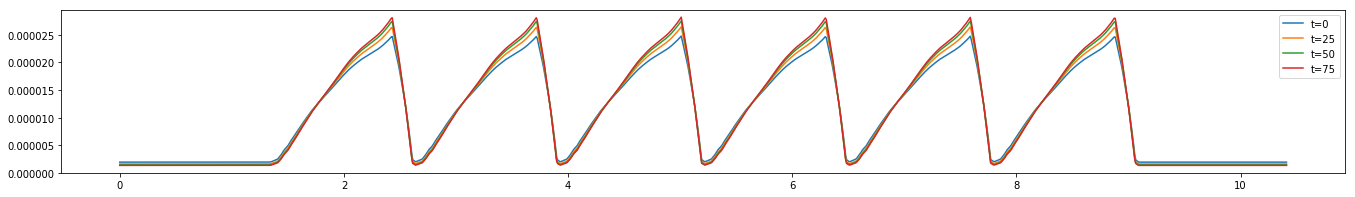

In [109]:
a = 0.0000127
b = 2
c = 0.2
d = -0.02



fig = plt.figure(figsize=(23, 3))
for t in range(0, 100, 25):
    decay = (1 - c*math.exp(d*(t)))
    qbedload = [a*(((z)/0.036)**decay) for z in z0]
    plt.plot(x0, qbedload, label='t={0}'.format(t))
    print(decay)
    

plt.legend()

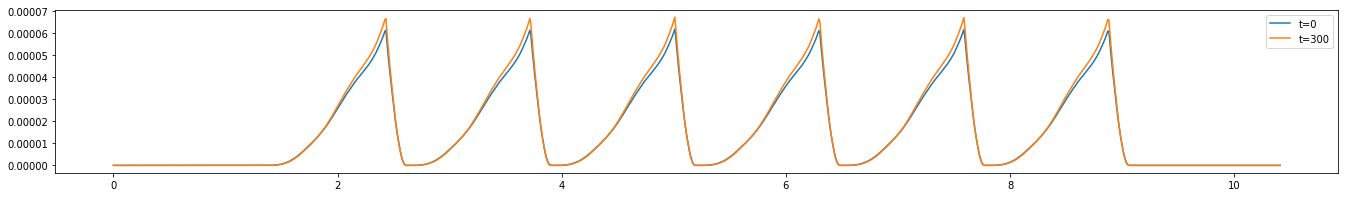

In [89]:
qsbmax = 0.0000127
delta = 0.036
zoffset = 0.0034
c = 1.
d = 0.02

qsbmodel = sdmodels.NonEquilibriumBedloadModel(qsbmax, delta, zoffset, c, d)
fig = plt.figure(figsize=(23, 3))
for t in range(0, 600, 300):
    qbedload = qsbmodel.calculate_bedload(0, 0, x0, z0, t)
    #qbedload = [qsbmax*((zs - zoffset)/delta)**(c*math.exp(d*t) + 1) for zs in z0]
    #qbedload = [qsbmax*((z)/delta)**(c*math.exp(d*(t))+ 1) for z in z0]
    plt.plot(x0, qbedload, label='t={0}'.format(t))
    

plt.legend()

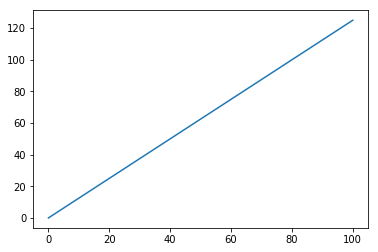

In [38]:
x0 = np.linspace(0, 100, 50)
y0 = [1.25 * x for x in x0]

plt.plot(x0, y0)

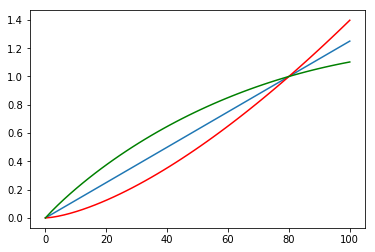

In [70]:
delta = 100.
qsbmax = 1.
qeq = [qsbmax*(z/delta) for z in y0]

qdecay = [qsbmax*(z/delta)**1.5 for z in y0]

qgrow = [ 2.0 * qsbmax*(z/delta) - (qsbmax*(z/delta)**1.5)   for z in y0]

plt.plot(x0, qeq)
plt.plot(x0, qdecay, 'r')
plt.plot(x0, qgrow, 'g')

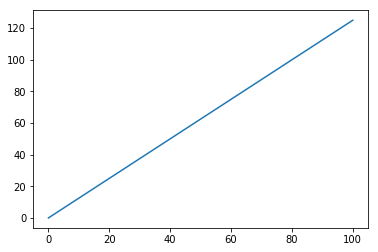

In [2]:
Lambda = 100.

x0 = np.linspace(0, Lambda, 50)
y0 = [1.25 * x for x in x0]

plt.plot(x0, y0)

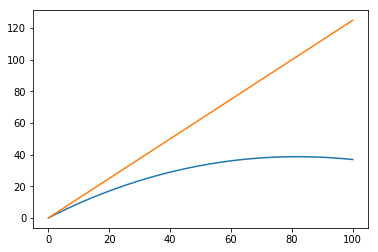

In [84]:
exponent = 1.9
q = [ x - (x**exponent)/Lambda for x in x0]
plt.plot(x0, q)
plt.plot(x0, y0)

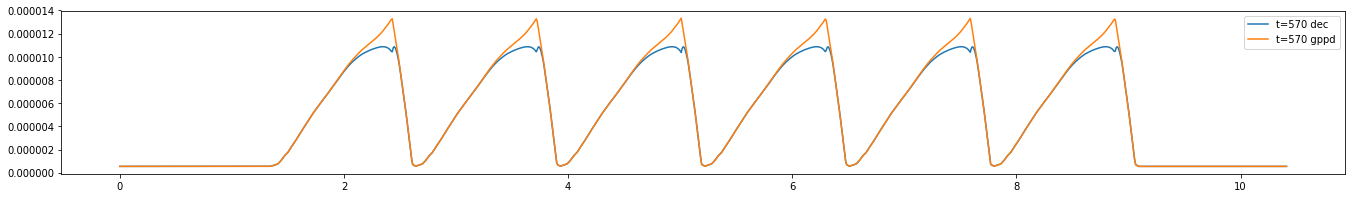

In [191]:
qsbmax = 0.0000127
delta = 0.079
zoffset = 0.0034
c = 1.
d = 0.02

exponent = 7
qsbmodel = sdmodels.NonEquilibriumBedloadModel2(qsbmax, delta, zoffset, c, d)
fig = plt.figure(figsize=(23, 3))
for t in range(0, 600, 30):
    #qbedload = qsbmodel.calculate_bedload(0, 0, x0, z0, t)  
    qbedload = [qsbmax*(((z)/0.079)) - 0.15 * qsbmax*(z/0.079)**exponent    for z in z0]
    

    qbedload2 = [qsbmax*(((z)/0.079)) for z in z0]
    
plt.plot(x0, qbedload, label='t={0} dec'.format(t))
plt.plot(x0, qbedload2, label='t={0} gppd'.format(t))
    

#plt.plot(x0, z0, label='t={0}'.format(t))
plt.legend()